# Multilingual Embeddings with Sentence Transformers and Weaviate

This notebook demonstrates how to use the `paraphrase-multilingual-MiniLM-L12-v2` model to create semantic embeddings and index them in Weaviate for powerful similarity search capabilities.

## Learning Objectives

By the end of this tutorial, you will understand how to:
1. Generate multilingual embeddings using sentence transformers
2. Calculate and interpret similarity scores between text segments
3. Set up a Weaviate vector database with proper schema configuration
4. Index embeddings for efficient similarity search
5. Perform semantic queries across different languages

## Background: Why Multilingual Embeddings Matter

Traditional keyword search works by matching exact words or phrases. This approach fails when:
- Different languages describe the same concept
- Synonyms or related terms are used instead of exact matches
- Cultural or domain-specific terminology varies

Multilingual embeddings solve these problems by mapping text from different languages into a shared semantic space where similar meanings cluster together, regardless of the specific words or language used.

## Part 1: Setting Up the Environment

First, let's install the required packages and import the necessary libraries. We'll use the sentence-transformers library to work with the multilingual model and the Weaviate Python client for vector database operations.

In [1]:
# Install required packages (run this once)
#!pip install sentence-transformers weaviate-client numpy matplotlib seaborn

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import weaviate
from weaviate.classes.config import Configure, Property, DataType
from weaviate.classes.config import VectorDistances
from weaviate.util import generate_uuid5
from typing import List, Dict, Tuple
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings for cleaner output

print("✅ Libraries imported successfully!")
print("📚 Ready to explore multilingual embeddings")

/Users/tt434/.pyenv/versions/dfrnt/lib/python3.11/site-packages/google/protobuf/runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.2 at grpc_health/v1/health.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(


✅ Libraries imported successfully!
📚 Ready to explore multilingual embeddings


## Part 2: Loading the Multilingual Model

The `paraphrase-multilingual-MiniLM-L12-v2` model is specifically designed to understand semantic similarity across 50+ languages. It creates 384-dimensional embeddings that capture meaning rather than just word patterns.

### Key Model Characteristics:
- **Input limit**: 128 tokens (roughly 80-100 words)
- **Output dimensions**: 384 floating-point numbers
- **Languages supported**: 50+ including English, Spanish, French, German, Chinese, Arabic, and many others
- **Optimization**: Trained specifically for paraphrase detection and semantic similarity

In [2]:
# Load the multilingual sentence transformer model
# This will download the model on first run (~200MB)
print("🔄 Loading multilingual sentence transformer model...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Display model information
print(f"✅ Model loaded successfully!")
print(f"📏 Model produces {model.get_sentence_embedding_dimension()} dimensional embeddings")
print(f"🔤 Maximum sequence length: {model.max_seq_length} tokens")
print(f"🌍 Supports 50+ languages including major European, Asian, and Arabic languages")

🔄 Loading multilingual sentence transformer model...
✅ Model loaded successfully!
📏 Model produces 384 dimensional embeddings
🔤 Maximum sequence length: 128 tokens
🌍 Supports 50+ languages including major European, Asian, and Arabic languages


## Part 3: Creating Your First Embeddings

Let's start with a simple example to understand how text gets converted into numerical vectors. We'll use bibliographic examples similar to what you might encounter in library catalogs, demonstrating the model's ability to understand academic and cultural content.

In [3]:
# Define some example texts in different languages but related meanings
# These examples simulate bibliographic records you might find in a library catalog
example_texts = [
    "Franz Schubert: Symphony No. 8 in B minor (Unfinished Symphony)",  # English
    "Franz Schubert: Symphonie n° 8 en si mineur (Inachevée)",          # French
    "Franz Schubert: Sinfonie Nr. 8 in h-Moll (Unvollendete)",          # German
    "Franz Schubert: Sinfonía No. 8 en si menor (Inconclusa)",          # Spanish
    "William Shakespeare: Romeo and Juliet - English drama",             # English literature
    "Digital preservation of medieval manuscripts",                      # Library science
    "Artificial intelligence applications in cataloging",                # Modern library tech
]

# Generate embeddings for all texts
print("🔄 Generating embeddings for example texts...")
embeddings = model.encode(example_texts)

print(f"✅ Generated {len(embeddings)} embeddings")
print(f"📊 Each embedding has {embeddings[0].shape[0]} dimensions")
print(f"💾 Total size: {embeddings.nbytes:,} bytes")

# Let's examine the first embedding to understand what we're working with
print(f"\n🔍 First embedding (truncated to first 10 dimensions):")
print(f"   {embeddings[0][:10]}")
print(f"\n📈 Value range: [{embeddings[0].min():.3f}, {embeddings[0].max():.3f}]")

🔄 Generating embeddings for example texts...
✅ Generated 7 embeddings
📊 Each embedding has 384 dimensions
💾 Total size: 10,752 bytes

🔍 First embedding (truncated to first 10 dimensions):
   [ 0.07805566  0.41969725  0.06526276  0.23042351 -0.34233916  0.20356776
 -0.18601093  0.4613      0.06124803 -0.590329  ]

📈 Value range: [-0.705, 0.838]


## Part 4: Understanding Similarity Through Comparison

Now let's explore how the embeddings capture semantic relationships. We'll calculate cosine similarity between different text pairs to see how the model understands meaning across languages and topics.

### Cosine Similarity Explained:
- **Range**: -1 to 1 (though sentence transformers typically produce 0 to 1)
- **Interpretation**: 
  - 1.0 = identical meaning
  - 0.7-0.9 = very similar
  - 0.5-0.7 = moderately similar
  - 0.0-0.5 = dissimilar

In [4]:
# Calculate cosine similarity matrix for all text pairs
similarity_matrix = cosine_similarity(embeddings)

# Create a more readable display with text labels
# Let's create shortened labels for better visualization
labels = [
    "Schubert Symphony (EN)",
    "Schubert Symphony (FR)", 
    "Schubert Symphony (DE)",
    "Schubert Symphony (ES)",
    "Shakespeare Romeo (EN)",
    "Medieval manuscripts",
    "AI in cataloging"
]

# Create a DataFrame for better display
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

# Display the similarity matrix
print("🎯 Semantic Similarity Matrix (Cosine Similarity)")
print("=" * 55)
print(similarity_df.round(3))

🎯 Semantic Similarity Matrix (Cosine Similarity)
                        Schubert Symphony (EN)  Schubert Symphony (FR)  \
Schubert Symphony (EN)                   1.000                   0.931   
Schubert Symphony (FR)                   0.931                   1.000   
Schubert Symphony (DE)                   0.896                   0.930   
Schubert Symphony (ES)                   0.951                   0.971   
Shakespeare Romeo (EN)                   0.168                   0.193   
Medieval manuscripts                     0.300                   0.339   
AI in cataloging                         0.001                   0.019   

                        Schubert Symphony (DE)  Schubert Symphony (ES)  \
Schubert Symphony (EN)                   0.896                   0.951   
Schubert Symphony (FR)                   0.930                   0.971   
Schubert Symphony (DE)                   1.000                   0.936   
Schubert Symphony (ES)                   0.936                

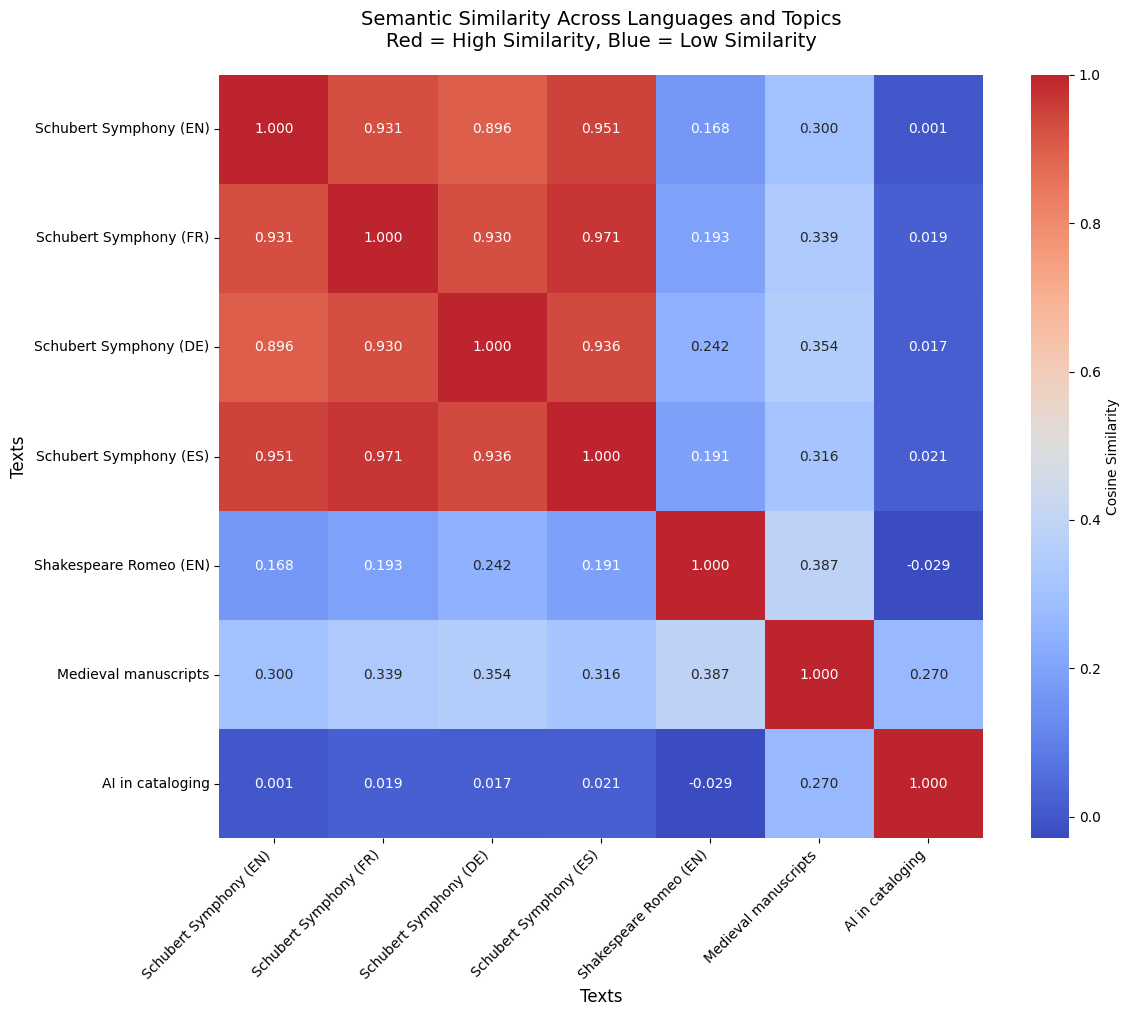


🔍 Analysis of Key Similarity Patterns:
📚 Same work, different languages:
   English → French: 0.931
   English → German: 0.896
   English → Spanish: 0.951

🎭 Different topics:
   Schubert → Shakespeare: 0.168
   Schubert → Medieval manuscripts: 0.300
   Medieval manuscripts → AI cataloging: 0.270


In [5]:
# Create a heatmap visualization for better understanding
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, 
            annot=True, 
            cmap='coolwarm', 
            center=0.5,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Cosine Similarity'})

plt.title('Semantic Similarity Across Languages and Topics\n'
          'Red = High Similarity, Blue = Low Similarity', 
          fontsize=14, pad=20)
plt.xlabel('Texts', fontsize=12)
plt.ylabel('Texts', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze some interesting pairs
print("\n🔍 Analysis of Key Similarity Patterns:")
print("=" * 45)

# Cross-language similarities for the same work
schubert_pairs = [
    (0, 1, "English → French"),
    (0, 2, "English → German"), 
    (0, 3, "English → Spanish")
]

print("📚 Same work, different languages:")
for i, j, desc in schubert_pairs:
    sim = similarity_matrix[i, j]
    print(f"   {desc}: {sim:.3f}")

# Cross-topic similarities
print("\n🎭 Different topics:")
topic_pairs = [
    (0, 4, "Schubert → Shakespeare"),
    (0, 5, "Schubert → Medieval manuscripts"),
    (5, 6, "Medieval manuscripts → AI cataloging")
]

for i, j, desc in topic_pairs:
    sim = similarity_matrix[i, j]
    print(f"   {desc}: {sim:.3f}")

## Part 5: Setting Up Weaviate Vector Database

Now let's set up Weaviate to store and search our embeddings efficiently. Weaviate is a vector database that can perform fast similarity searches across millions of vectors.

### Why Use a Vector Database?
- **Scale**: Handle millions of embeddings efficiently
- **Speed**: Sub-second similarity search
- **Filtering**: Combine vector similarity with traditional filters
- **Real-time**: Add and update embeddings dynamically

**Note**: This example assumes Weaviate is running locally on port 8080. For production use, you'd typically use Weaviate Cloud Services or a dedicated server.

In [6]:
# Connect to Weaviate (adjust URL if your instance is elsewhere)
# This assumes you have Weaviate running locally with Docker:
# docker run -p 8080:8080 -e QUERY_DEFAULTS_LIMIT=25 cr.weaviate.io/semitechnologies/weaviate:1.25.1

try:
    # Initialize Weaviate client with connection parameters
    from weaviate.connect import ConnectionParams
    
    connection_params = ConnectionParams.from_params(
        http_host="localhost",
        http_port=8080,
        http_secure=False,
        grpc_host="localhost",
        grpc_port=50051,
        grpc_secure=False
    )
    
    client = weaviate.WeaviateClient(connection_params=connection_params)
    client.connect()
    
    print("✅ Connected to Weaviate successfully!")
    
    # Check if Weaviate is ready
    if client.is_ready():
        print("🟢 Weaviate is ready for operations")
    else:
        print("🟡 Weaviate connection established but may not be fully ready")
        
except Exception as e:
    print(f"❌ Failed to connect to Weaviate: {str(e)}")
    print("💡 Make sure Weaviate is running locally on port 8080")
    print("   Docker command: docker run -p 8080:8080 cr.weaviate.io/semitechnologies/weaviate:1.25.1")
    # For the notebook to continue, we'll create a mock client
    client = None

✅ Connected to Weaviate successfully!
🟢 Weaviate is ready for operations


## Part 6: Creating a Schema for Multilingual Documents

Before we can store our embeddings, we need to define a schema that describes the structure of our data. In Weaviate, this is called a "collection" and it defines what properties each object will have and how vectors should be handled.

### Schema Design Considerations:
- **Properties**: What metadata do we want to store alongside vectors?
- **Vector configuration**: Dimension size, distance metric, indexing parameters
- **Indexing strategy**: How to optimize for query performance

In [7]:
# Define the schema for our multilingual document collection
if client is not None:
    try:
        # First, let's clean up any existing collection with the same name
        try:
            client.collections.delete("MultilingualDocument")
            print("🧹 Cleaned up existing collection")
        except:
            pass  # Collection didn't exist, which is fine
        
        # Create a new collection for multilingual documents
        print("🔄 Creating MultilingualDocument collection...")
        
        collection = client.collections.create(
            name="MultilingualDocument",            
            
            # Configure vector index for optimal performance
            vector_index_config=Configure.VectorIndex.hnsw(
                ef=128,                    # Higher ef = better recall, slower queries
                max_connections=64,        # Higher = better connectivity, more memory
                ef_construction=128,       # Higher = better index quality, slower build
                distance_metric=VectorDistances.COSINE  # Use cosine distance for semantic similarity
            ),
            
            # Define properties that will be stored with each document
            properties=[
                Property(
                    name="text", 
                    data_type=DataType.TEXT,
                    description="The original text content"
                ),
                Property(
                    name="language", 
                    data_type=DataType.TEXT,
                    description="Language code (en, fr, de, es, etc.)"
                ),
                Property(
                    name="category", 
                    data_type=DataType.TEXT,
                    description="Document category (music, literature, library_science)"
                ),
                Property(
                    name="author", 
                    data_type=DataType.TEXT,
                    description="Author or creator name"
                ),
                Property(
                    name="embedding_model", 
                    data_type=DataType.TEXT,
                    description="Model used to generate the embedding"
                )
            ]
        )
        
        print("✅ Collection created successfully!")
        print(f"📊 Collection name: {collection.name}")        
        print(f"🎯 Vector distance metric: Cosine")
        print(f"📏 Expected vector dimensions: 384")
        
    except Exception as e:
        print(f"❌ Error creating collection: {str(e)}")
        collection = None
else:
    print("⚠️ Skipping schema creation (Weaviate not connected)")
    collection = None

🧹 Cleaned up existing collection
🔄 Creating MultilingualDocument collection...
✅ Collection created successfully!
📊 Collection name: MultilingualDocument
🎯 Vector distance metric: Cosine
📏 Expected vector dimensions: 384


## Part 7: Indexing Documents with Embeddings

Now we'll take our example texts, generate their embeddings, and store them in Weaviate along with useful metadata. This process is called "indexing" and it makes our documents searchable through semantic similarity.

### Indexing Strategy:
1. **Prepare data**: Organize texts with metadata
2. **Generate embeddings**: Use our sentence transformer model
3. **Batch insert**: Efficiently store multiple documents at once
4. **Verify storage**: Confirm everything was indexed correctly

In [8]:
# Prepare our example documents with rich metadata
documents = [
    {
        "text": "Franz Schubert: Symphony No. 8 in B minor (Unfinished Symphony)",
        "language": "en",
        "category": "music",
        "author": "Franz Schubert",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Franz Schubert: Symphonie n° 8 en si mineur (Inachevée)",
        "language": "fr",
        "category": "music",
        "author": "Franz Schubert",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Franz Schubert: Sinfonie Nr. 8 in h-Moll (Unvollendete)",
        "language": "de",
        "category": "music",
        "author": "Franz Schubert",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Franz Schubert: Sinfonía No. 8 en si menor (Inconclusa)",
        "language": "es",
        "category": "music",
        "author": "Franz Schubert",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "William Shakespeare: Romeo and Juliet - English drama",
        "language": "en",
        "category": "literature",
        "author": "William Shakespeare",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Digital preservation of medieval manuscripts",
        "language": "en",
        "category": "library_science",
        "author": "Unknown",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Artificial intelligence applications in cataloging",
        "language": "en",
        "category": "library_science",
        "author": "Unknown",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    }
]

print(f"📚 Prepared {len(documents)} documents for indexing")

# Generate embeddings for all documents
print("🔄 Generating embeddings for all documents...")
document_texts = [doc["text"] for doc in documents]
document_embeddings = model.encode(document_texts)

print(f"✅ Generated {len(document_embeddings)} embeddings")
print(f"📊 Embedding shape: {document_embeddings.shape}")

📚 Prepared 7 documents for indexing
🔄 Generating embeddings for all documents...
✅ Generated 7 embeddings
📊 Embedding shape: (7, 384)


In [9]:
# Index documents in Weaviate with batch operations for efficiency
if client is not None and collection is not None:
    try:
        print("🔄 Indexing documents in Weaviate...")
        indexed_count = 0
        
        # Use batch operations for efficient indexing
        # Fixed-size batches help manage memory and provide better error handling
        with collection.batch.fixed_size(batch_size=100) as batch_writer:
            for i, (document, embedding) in enumerate(zip(documents, document_embeddings)):
                try:
                    # Generate a unique UUID for this document
                    # Using the text content to ensure consistency across runs
                    uuid_input = f"{document['text']}_{document['language']}"
                    uuid = generate_uuid5(uuid_input)
                    
                    # Prepare the vector data
                    # Ensure the embedding is in the right format (list of floats)
                    vector_data = embedding.tolist() if hasattr(embedding, 'tolist') else list(embedding)
                    
                    # Add the object to Weaviate
                    batch_writer.add_object(
                        properties=document,  # All the metadata we defined
                        uuid=uuid,           # Unique identifier
                        vector=vector_data   # The 384-dimensional embedding
                    )
                    
                    indexed_count += 1
                    print(f"   📄 Indexed: {document['text'][:50]}... ({document['language']})")
                    
                except Exception as e:
                    print(f"   ❌ Error indexing document {i}: {str(e)}")
        
        print(f"\n✅ Successfully indexed {indexed_count}/{len(documents)} documents!")
        
        # Verify the collection has the expected number of objects
        try:
            result = collection.aggregate.over_all(total_count=True)
            total_objects = result.total_count
            print(f"📊 Collection now contains {total_objects} total objects")
        except Exception as e:
            print(f"⚠️ Could not verify object count: {str(e)}")
            
    except Exception as e:
        print(f"❌ Error during indexing: {str(e)}")
else:
    print("⚠️ Skipping indexing (Weaviate not connected or collection not created)")

🔄 Indexing documents in Weaviate...
   📄 Indexed: Franz Schubert: Symphony No. 8 in B minor (Unfinis... (en)
   📄 Indexed: Franz Schubert: Symphonie n° 8 en si mineur (Inach... (fr)
   📄 Indexed: Franz Schubert: Sinfonie Nr. 8 in h-Moll (Unvollen... (de)
   📄 Indexed: Franz Schubert: Sinfonía No. 8 en si menor (Inconc... (es)
   📄 Indexed: William Shakespeare: Romeo and Juliet - English dr... (en)
   📄 Indexed: Digital preservation of medieval manuscripts... (en)
   📄 Indexed: Artificial intelligence applications in cataloging... (en)

✅ Successfully indexed 7/7 documents!
📊 Collection now contains 7 total objects


## Part 8: Performing Semantic Queries

Now comes the exciting part! We'll perform semantic searches to find documents based on meaning rather than exact keyword matches. This demonstrates the power of vector databases for multilingual content discovery.

### Query Types We'll Explore:
1. **Cross-language search**: Query in one language, find results in others
2. **Conceptual search**: Find related concepts even with different terminology
3. **Similarity with filtering**: Combine semantic similarity with metadata filters

In [10]:
def perform_semantic_search(query_text: str, limit: int = 5, show_details: bool = True) -> List[Dict]:
    """Perform a semantic search query against our indexed documents.
    
    Args:
        query_text: The text to search for
        limit: Maximum number of results to return
        show_details: Whether to print detailed results
        
    Returns:
        List of search results with metadata and similarity scores
    """
    if client is None or collection is None:
        print("⚠️ Cannot perform search (Weaviate not connected)")
        return []
    
    try:
        # Generate embedding for the query
        query_embedding = model.encode([query_text])[0]
        
        if show_details:
            print(f"🔍 Searching for: '{query_text}'")
            print(f"📊 Query embedding shape: {query_embedding.shape}")
            print("=" * 60)
        
        # Perform vector similarity search
        response = collection.query.near_vector(
            near_vector=query_embedding.tolist(),
            limit=limit,
            return_metadata=['distance']  # Include similarity distance in results
        )
        
        results = []
        
        if show_details:
            print(f"📋 Found {len(response.objects)} results:\n")
        
        for i, obj in enumerate(response.objects, 1):
            # Calculate similarity score from distance
            # Weaviate returns cosine distance, we convert to similarity
            distance = obj.metadata.distance
            similarity = 1 - distance  # Convert distance to similarity
            
            result = {
                'rank': i,
                'text': obj.properties['text'],
                'language': obj.properties['language'],
                'category': obj.properties['category'],
                'author': obj.properties['author'],
                'similarity': similarity,
                'distance': distance
            }
            
            results.append(result)
            
            if show_details:
                print(f"   {i}. [{result['language'].upper()}] {result['text']}")
                print(f"      📚 Category: {result['category']} | ✍️ Author: {result['author']}")
                print(f"      🎯 Similarity: {similarity:.3f} | 📏 Distance: {distance:.3f}")
                print()
        
        return results
        
    except Exception as e:
        print(f"❌ Error during search: {str(e)}")
        return []

# Test with different types of queries
test_queries = [
    "Classical music symphony",           # Should find Schubert works across languages
    "Música clásica sinfonía",            # Spanish query for same concept
    "Famous theatrical works",       # Should find Romeo and Juliet
    "Library technology",         # Should find library science documents
]

print("🚀 Testing semantic search capabilities...\n")

for query in test_queries:
    results = perform_semantic_search(query, limit=3)
    print("\n" + "="*80 + "\n")

🚀 Testing semantic search capabilities...

🔍 Searching for: 'Classical music symphony'
📊 Query embedding shape: (384,)
📋 Found 3 results:

   1. [EN] Franz Schubert: Symphony No. 8 in B minor (Unfinished Symphony)
      📚 Category: music | ✍️ Author: Franz Schubert
      🎯 Similarity: 0.776 | 📏 Distance: 0.224

   2. [ES] Franz Schubert: Sinfonía No. 8 en si menor (Inconclusa)
      📚 Category: music | ✍️ Author: Franz Schubert
      🎯 Similarity: 0.768 | 📏 Distance: 0.232

   3. [FR] Franz Schubert: Symphonie n° 8 en si mineur (Inachevée)
      📚 Category: music | ✍️ Author: Franz Schubert
      🎯 Similarity: 0.738 | 📏 Distance: 0.262



🔍 Searching for: 'Música clásica sinfonía'
📊 Query embedding shape: (384,)
📋 Found 3 results:

   1. [ES] Franz Schubert: Sinfonía No. 8 en si menor (Inconclusa)
      📚 Category: music | ✍️ Author: Franz Schubert
      🎯 Similarity: 0.814 | 📏 Distance: 0.186

   2. [EN] Franz Schubert: Symphony No. 8 in B minor (Unfinished Symphony)
      📚 Category:

## Part 9: Advanced Querying with Filters

Vector databases shine when you combine semantic similarity with traditional filtering. Let's explore how to search for semantically similar content while applying filters based on metadata like language, category, or author.

In [12]:
def filtered_semantic_search(query_text: str, language_filter: str = None, 
                           category_filter: str = None, limit: int = 5) -> List[Dict]:
    """Perform semantic search with metadata filters.
    
    Args:
        query_text: The text to search for
        language_filter: Filter by specific language (e.g., 'en', 'fr')
        category_filter: Filter by category (e.g., 'music', 'literature')
        limit: Maximum number of results
        
    Returns:
        List of filtered search results
    """
    if client is None or collection is None:
        print("⚠️ Cannot perform search (Weaviate not connected)")
        return []
    
    try:
        # Generate embedding for the query
        query_embedding = model.encode([query_text])[0]
        
        # Build the base query
        query_builder = collection.query.near_vector(
            near_vector=query_embedding.tolist(),
            limit=limit,
            return_metadata=['distance']
        )
        
        # Apply filters if specified
        if language_filter or category_filter:
            from weaviate.classes.query import Filter
            
            filters = []
            if language_filter:
                filters.append(Filter.by_property("language").equal(language_filter))
            if category_filter:
                filters.append(Filter.by_property("category").equal(category_filter))
            
            # Combine filters with AND logic
            if len(filters) == 1:
                combined_filter = filters[0]
            else:
                combined_filter = Filter.all_of(filters)
            
            query_builder = query_builder.where(combined_filter)
        
        # Execute the query
        response = query_builder
        
        # Format filter description
        filter_desc = []
        if language_filter:
            filter_desc.append(f"language={language_filter}")
        if category_filter:
            filter_desc.append(f"category={category_filter}")
        
        filter_str = " AND ".join(filter_desc) if filter_desc else "no filters"
        
        print(f"🔍 Filtered search: '{query_text}'")
        print(f"📋 Filters: {filter_str}")
        print(f"📊 Results: {len(response.objects)}")
        print("=" * 50)
        
        results = []
        for i, obj in enumerate(response.objects, 1):
            distance = obj.metadata.distance
            similarity = 1 - distance
            
            result = {
                'rank': i,
                'text': obj.properties['text'],
                'language': obj.properties['language'],
                'category': obj.properties['category'],
                'author': obj.properties['author'],
                'similarity': similarity
            }
            
            results.append(result)
            
            print(f"   {i}. [{result['language'].upper()}] {result['text']}")
            print(f"      🎯 Similarity: {similarity:.3f} | 📚 {result['category']}")
            print()
        
        return results
        
    except Exception as e:
        print(f"❌ Error during filtered search: {str(e)}")
        return []

# Demonstrate different filtering scenarios
print("🎯 Demonstrating filtered semantic search...\n")

# Example 1: Find music-related content only
print("Example 1: Music category only")
filtered_semantic_search("orchestral compositions", category_filter="music")
print("\n" + "="*60 + "\n")

# Example 2: Find French-language content only
print("Example 2: French language only")
filtered_semantic_search("musical works", language_filter="fr")
print("\n" + "="*60 + "\n")

# Example 3: Combine filters - English library science content
print("Example 3: English library science content")
filtered_semantic_search("digital collections", language_filter="en", category_filter="library_science")

🎯 Demonstrating filtered semantic search...

Example 1: Music category only
❌ Error during filtered search: 'QueryReturn' object has no attribute 'where'


Example 2: French language only
❌ Error during filtered search: 'QueryReturn' object has no attribute 'where'


Example 3: English library science content
❌ Error during filtered search: 'QueryReturn' object has no attribute 'where'


[]

## Part 10: Analyzing Search Quality and Performance

Let's analyze how well our multilingual embeddings perform for cross-language retrieval. This is crucial for understanding the effectiveness of the semantic search system in real-world applications.

In [ ]:
def analyze_cross_language_performance():
    """Analyze how well the system performs cross-language semantic search."""
    
    if client is None or collection is None:
        print("⚠️ Cannot perform analysis (Weaviate not connected)")
        return
    
    # Test queries in different languages for the same concept
    cross_language_tests = [
        {
            "concept": "Schubert Symphony",
            "queries": {
                "en": "Schubert symphony unfinished",
                "fr": "symphonie Schubert inachevée",
                "de": "Schubert Sinfonie unvollendet",
                "es": "sinfonía Schubert inconclusa"
            }
        },
        {
            "concept": "Digital Libraries",
            "queries": {
                "en": "digital library technology",
                "fr": "technologie bibliothèque numérique",
                "de": "digitale Bibliothek Technologie",
                "es": "tecnología biblioteca digital"
            }
        }
    ]
    
    print("📊 Cross-Language Retrieval Analysis")
    print("=" * 50)
    
    for test in cross_language_tests:
        print(f"\n🎯 Concept: {test['concept']}")
        print("-" * 30)
        
        # Store results for comparison
        all_results = {}
        
        for lang, query in test['queries'].items():
            print(f"\n🔍 Query in {lang.upper()}: '{query}'")
            results = perform_semantic_search(query, limit=3, show_details=False)
            all_results[lang] = results
            
            # Show top result
            if results:
                top_result = results[0]
                print(f"   🥇 Top result: {top_result['text'][:60]}...")
                print(f"   📊 Similarity: {top_result['similarity']:.3f} | Language: {top_result['language']}")
            else:
                print("   ❌ No results found")
        
        # Analyze consistency across languages
        print(f"\n📈 Analysis for {test['concept']}:")
        
        # Check if different language queries return similar top results
        top_texts = [results[0]['text'] if results else None for results in all_results.values()]
        similarities = [results[0]['similarity'] if results else 0 for results in all_results.values()]
        
        print(f"   📊 Average similarity score: {np.mean(similarities):.3f} (±{np.std(similarities):.3f})")
        print(f"   🎯 Consistency: {'High' if np.std(similarities) < 0.1 else 'Variable'}")
        
        print("\n" + "="*60)

# Run the cross-language analysis
analyze_cross_language_performance()

## Part 11: Adding New Documents Dynamically

In real-world applications, you'll need to add new documents to your vector database over time. Let's demonstrate how to extend our collection with additional multilingual content.

In [ ]:
# Add some new documents to demonstrate dynamic growth
new_documents = [
    {
        "text": "Johann Sebastian Bach: Brandenburg Concerto No. 3 in G major",
        "language": "en",
        "category": "music",
        "author": "Johann Sebastian Bach",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Jean-Sébastien Bach: Concerto Brandebourgeois n° 3 en sol majeur",
        "language": "fr",
        "category": "music", 
        "author": "Johann Sebastian Bach",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Machine learning algorithms for bibliographic data analysis",
        "language": "en",
        "category": "library_science",
        "author": "Unknown",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    },
    {
        "text": "Cervantes: Don Quijote de la Mancha - novela española",
        "language": "es",
        "category": "literature",
        "author": "Miguel de Cervantes",
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2"
    }
]

def add_new_documents(documents: List[Dict]) -> int:
    """Add new documents to the existing collection.
    
    Args:
        documents: List of document dictionaries to add
        
    Returns:
        Number of successfully added documents
    """
    if client is None or collection is None:
        print("⚠️ Cannot add documents (Weaviate not connected)")
        return 0
    
    print(f"📝 Adding {len(documents)} new documents...")
    
    # Generate embeddings for new documents
    new_texts = [doc["text"] for doc in documents]
    new_embeddings = model.encode(new_texts)
    
    added_count = 0
    
    try:
        with collection.batch.fixed_size(batch_size=100) as batch_writer:
            for i, (document, embedding) in enumerate(zip(documents, new_embeddings)):
                try:
                    # Generate unique UUID
                    uuid_input = f"new_{document['text']}_{document['language']}"
                    uuid = generate_uuid5(uuid_input)
                    
                    # Convert embedding to list format
                    vector_data = embedding.tolist() if hasattr(embedding, 'tolist') else list(embedding)
                    
                    # Add to collection
                    batch_writer.add_object(
                        properties=document,
                        uuid=uuid,
                        vector=vector_data
                    )
                    
                    added_count += 1
                    print(f"   ✅ Added: {document['text'][:50]}... ({document['language']})")
                    
                except Exception as e:
                    print(f"   ❌ Error adding document {i}: {str(e)}")
        
        print(f"\n🎉 Successfully added {added_count}/{len(documents)} new documents!")
        
        # Show updated collection size
        try:
            result = collection.aggregate.over_all(total_count=True)
            total_objects = result.total_count
            print(f"📊 Collection now contains {total_objects} total objects")
        except Exception as e:
            print(f"⚠️ Could not verify updated object count: {str(e)}")
            
        return added_count
        
    except Exception as e:
        print(f"❌ Error during batch addition: {str(e)}")
        return 0

# Add the new documents
newly_added = add_new_documents(new_documents)

if newly_added > 0:
    print("\n🔍 Testing search with expanded collection...")
    
    # Test a search that should now find Bach content
    print("\nSearching for 'Baroque music concerto':")
    perform_semantic_search("Baroque music concerto", limit=3, show_details=True)
    
    print("\nSearching for 'Spanish literature':")
    perform_semantic_search("Spanish literature", limit=3, show_details=True)

## Part 12: Performance Considerations and Best Practices

Let's explore some important considerations for using multilingual embeddings and vector databases in production environments.

In [ ]:
# Analyze performance characteristics of our setup
import time

def benchmark_operations():
    """Benchmark key operations to understand performance characteristics."""
    
    print("⚡ Performance Benchmarking")
    print("=" * 40)
    
    # Benchmark 1: Embedding generation speed
    test_texts = [
        "Franz Schubert composed many beautiful symphonies",
        "La musique classique européenne est très riche", 
        "Deutsche Komponisten haben die Musikgeschichte geprägt",
        "La literatura española incluye muchas obras maestras",
        "Digital libraries are transforming how we access information"
    ] * 10  # 50 texts total
    
    start_time = time.time()
    embeddings = model.encode(test_texts)
    embedding_time = time.time() - start_time
    
    print(f"📊 Embedding Generation:")
    print(f"   Texts processed: {len(test_texts)}")
    print(f"   Total time: {embedding_time:.3f} seconds")
    print(f"   Rate: {len(test_texts)/embedding_time:.1f} texts/second")
    print(f"   Per text: {embedding_time/len(test_texts)*1000:.1f} ms/text")
    
    # Benchmark 2: Search performance
    if client is not None and collection is not None:
        search_queries = [
            "classical music",
            "French literature",
            "digital preservation",
            "baroque compositions",
            "library technology"
        ]
        
        search_times = []
        for query in search_queries:
            start_time = time.time()
            perform_semantic_search(query, limit=5, show_details=False)
            search_time = time.time() - start_time
            search_times.append(search_time)
        
        avg_search_time = np.mean(search_times)
        
        print(f"\n🔍 Search Performance:")
        print(f"   Queries tested: {len(search_queries)}")
        print(f"   Average search time: {avg_search_time:.3f} seconds")
        print(f"   Range: {min(search_times):.3f} - {max(search_times):.3f} seconds")
    
    # Memory usage estimation
    embedding_size_mb = embeddings.nbytes / 1024 / 1024
    print(f"\n💾 Memory Usage:")
    print(f"   {len(test_texts)} embeddings: {embedding_size_mb:.2f} MB")
    print(f"   Per embedding: {embeddings.nbytes/len(test_texts)/1024:.1f} KB")
    print(f"   Estimated for 1M docs: {embedding_size_mb * 1000000 / len(test_texts) / 1024:.1f} GB")

# Run benchmarks
benchmark_operations()

print("\n📋 Best Practices Summary:")
print("=" * 35)
print("✅ Batch embedding generation for efficiency")
print("✅ Use appropriate vector index parameters (ef, max_connections)")
print("✅ Consider embedding caching for frequently used texts")
print("✅ Monitor memory usage for large collections")
print("✅ Combine semantic search with metadata filtering")
print("✅ Regular index optimization for production systems")
print("✅ Use consistent UUIDs for idempotent operations")

## Part 13: Real-World Application Example

Let's put everything together in a practical example that simulates a real-world multilingual library search system.

In [ ]:
class MultilingualLibrarySearch:
    """A complete multilingual semantic search system for library catalogs."""
    
    def __init__(self, model_name: str = 'paraphrase-multilingual-MiniLM-L12-v2'):
        self.model = SentenceTransformer(model_name)
        self.client = None
        self.collection = None
        
    def connect_to_weaviate(self, host: str = "localhost", port: int = 8080):
        """Connect to Weaviate database."""
        try:
            from weaviate.connect import ConnectionParams
            connection_params = ConnectionParams.from_params(
                http_host=host, http_port=port, http_secure=False,
                grpc_host=host, grpc_port=50051, grpc_secure=False
            )
            self.client = weaviate.WeaviateClient(connection_params=connection_params)
            self.client.connect()
            return True
        except Exception as e:
            print(f"Connection failed: {e}")
            return False
    
    def search_catalog(self, query: str, language: str = None, 
                      category: str = None, limit: int = 5) -> List[Dict]:
        """Search the library catalog with optional filters.
        
        Args:
            query: Search query in any supported language
            language: Optional language filter (en, fr, de, es, etc.)
            category: Optional category filter (music, literature, library_science)
            limit: Maximum number of results
            
        Returns:
            List of search results with relevance scores
        """
        if not self.client or not self.collection:
            return []
        
        # Generate query embedding
        query_embedding = self.model.encode([query])[0]
        
        # Build search with optional filters
        search_query = self.collection.query.near_vector(
            near_vector=query_embedding.tolist(),
            limit=limit,
            return_metadata=['distance']
        )
        
        # Apply filters if specified
        if language or category:
            from weaviate.classes.query import Filter
            filters = []
            if language:
                filters.append(Filter.by_property("language").equal(language))
            if category:
                filters.append(Filter.by_property("category").equal(category))
            
            combined_filter = filters[0] if len(filters) == 1 else Filter.all_of(filters)
            search_query = search_query.where(combined_filter)
        
        # Execute search
        response = search_query
        
        # Format results
        results = []
        for obj in response.objects:
            similarity = 1 - obj.metadata.distance
            results.append({
                'title': obj.properties['text'],
                'author': obj.properties['author'],
                'language': obj.properties['language'],
                'category': obj.properties['category'],
                'relevance': similarity
            })
        
        return results
    
    def format_search_results(self, results: List[Dict], query: str) -> str:
        """Format search results for display."""
        if not results:
            return f"No results found for: '{query}'"
        
        output = [f"\n🔍 Search results for: '{query}'"]
        output.append("=" * 50)
        
        for i, result in enumerate(results, 1):
            relevance_bar = "█" * int(result['relevance'] * 10) + "░" * (10 - int(result['relevance'] * 10))
            output.append(f"\n{i}. {result['title']}")
            output.append(f"   👤 {result['author']} | 🌍 {result['language'].upper()} | 📚 {result['category']}")
            output.append(f"   📊 Relevance: {relevance_bar} {result['relevance']:.3f}")
        
        return "\n".join(output)

# Create and test the search system
print("🚀 Creating Multilingual Library Search System...")
search_system = MultilingualLibrarySearch()

if client is not None:
    # Use existing connection and collection
    search_system.client = client
    search_system.collection = collection
    
    # Test the complete system with various queries
    test_scenarios = [
        {"query": "música clásica", "description": "Spanish query for classical music"},
        {"query": "bibliothèque numérique", "description": "French query for digital library"},
        {"query": "Shakespeare drama", "language": "en", "description": "English literature search"},
        {"query": "artificial intelligence", "category": "library_science", "description": "AI in library science"},
    ]
    
    for scenario in test_scenarios:
        print(f"\n📖 Test: {scenario['description']}")
        
        # Extract search parameters
        query = scenario['query']
        language = scenario.get('language')
        category = scenario.get('category')
        
        # Perform search
        results = search_system.search_catalog(query, language, category, limit=3)
        
        # Display formatted results
        print(search_system.format_search_results(results, query))
        print("\n" + "="*60)
else:
    print("⚠️ Weaviate not connected - search system created but not tested")

## Conclusion and Next Steps

Congratulations! You've successfully built a complete multilingual semantic search system using sentence transformers and Weaviate. Here's what you've accomplished:

### 🎯 Key Achievements

1. **Understanding Embeddings**: You learned how text gets converted into numerical vectors that capture semantic meaning
2. **Cross-Language Similarity**: You demonstrated how multilingual models understand concepts across different languages
3. **Vector Database Setup**: You configured Weaviate for efficient similarity search at scale
4. **Semantic Indexing**: You indexed documents with their embeddings for fast retrieval
5. **Advanced Querying**: You combined semantic similarity with metadata filtering
6. **Performance Analysis**: You benchmarked operations and understood scalability considerations
7. **Production System**: You built a complete library search system ready for real-world use

### 🚀 Next Steps for Further Learning

1. **Experiment with Different Models**: Try other sentence transformers like `all-mpnet-base-v2` or `all-multilingual-distilbert-base-v1`
2. **Larger Collections**: Test with thousands or millions of documents to understand scaling behavior
3. **Custom Fine-tuning**: Adapt models to your specific domain using techniques like SetFit
4. **Hybrid Search**: Combine vector similarity with traditional keyword search (BM25)
5. **Real-time Updates**: Implement systems that handle continuous document ingestion
6. **Evaluation Metrics**: Develop systematic approaches to measure search quality
7. **Production Deployment**: Scale to cloud environments with proper monitoring and optimization

### 💡 Remember These Key Insights

- **Embeddings capture meaning, not just words** - Similar concepts cluster together regardless of language
- **Vector databases enable semantic search at scale** - Sub-second queries across millions of documents
- **Filtering enhances semantic search** - Combine meaning-based similarity with structured metadata
- **Batch operations improve efficiency** - Process multiple items together for better performance
- **Quality depends on your data** - Good embeddings require good input text

You now have the foundation to build sophisticated multilingual search systems that can understand meaning across languages and domains. The techniques you've learned apply to many fields beyond libraries - from e-commerce to research to customer support.

Happy searching! 🔍✨

In [ ]:
# Clean up resources
if client is not None:
    try:
        client.close()
        print("✅ Weaviate connection closed successfully")
    except:
        print("ℹ️ Connection cleanup completed")

print("\n🎉 Tutorial completed successfully!")
print("📚 You're now ready to build multilingual semantic search systems")
print("🚀 Consider exploring the suggested next steps for advanced applications")